In [3]:
# import the libraries as shown below

import tensorflow 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, experimental, Lambda

# Check Existance of bad files

In [4]:
import os
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir ='../data/external/cell_images'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Parasitized
processing class directory  Uninfected
 no improper image files were found


In [5]:
# Split the data After removing corrupted Images
import splitfolders
splitfolders.ratio('../data/external/cell_images', output="../data/interim/dataset", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2000 files [00:02, 718.29 files/s]


In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

train_generator = train_datagen.flow_from_directory(
    '../data/interim/dataset/train',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'sparse',
    save_to_dir = "../data/interim/augmentedcnn"
)

Found 5136 images belonging to 2 classes.


In [7]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

validation_generator = validation_datagen.flow_from_directory(
    '../data/interim/dataset/val',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 866 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 10
)

# in the anaconda_prompt write "mkdir augmented" to ccreate file to put the augmented images in it 

test_generator = test_datagen.flow_from_directory(
    '../data/interim/dataset/test',
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical')

Found 859 images belonging to 2 classes.


In [9]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [11]:
history = model.fit(train_generator, 
                    steps_per_epoch = 47, 
                    verbose = 1, 
                    validation_data = validation_generator,
                       validation_steps = 6,
                   epochs = 30)

Epoch 1/30
47/47 [==============================] - 84s 2s/step - loss: 0.6385 - accuracy: 0.6170 - val_loss: 0.5995 - val_accuracy: 0.7240
Epoch 2/30
47/47 [==============================] - 83s 2s/step - loss: 0.5110 - accuracy: 0.7434 - val_loss: 0.5019 - val_accuracy: 0.7500
Epoch 3/30
47/47 [==============================] - 82s 2s/step - loss: 0.3728 - accuracy: 0.8421 - val_loss: 0.5013 - val_accuracy: 0.7812
Epoch 4/30
47/47 [==============================] - 84s 2s/step - loss: 0.2888 - accuracy: 0.9089 - val_loss: 0.2631 - val_accuracy: 0.9062
Epoch 5/30
47/47 [==============================] - 87s 2s/step - loss: 0.2423 - accuracy: 0.9099 - val_loss: 0.2171 - val_accuracy: 0.9271
Epoch 6/30
47/47 [==============================] - 88s 2s/step - loss: 0.1896 - accuracy: 0.9355 - val_loss: 0.1156 - val_accuracy: 0.9635
Epoch 7/30
47/47 [==============================] - 92s 2s/step - loss: 0.1490 - accuracy: 0.9574 - val_loss: 0.1505 - val_accuracy: 0.9323
Epoch 8/30
47/47 [==

In [12]:
scores = model.evaluate(test_generator)
scores

27/27 [==============================] - 17s 641ms/step - loss: 2.6867 - accuracy: 0.5000


[2.6866657733917236, 0.5]

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

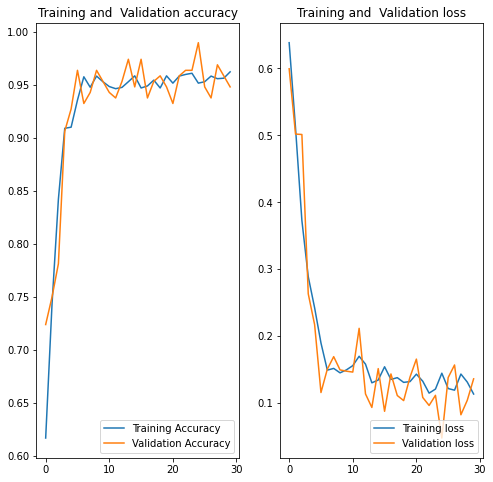

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label = 'Training Accuracy')
plt.plot(range(30), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and  Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label = 'Training loss')
plt.plot(range(30), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and  Validation loss')

plt.show()
plt.savefig('../reports/figures/AccVal_accCNN.jpg')

In [23]:
# Save the mdel to be used in google Cloud

model.save('../models/Parasite_CNN.h5')